In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score,fbeta_score, jaccard_score

import os
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
import visualkeras

/Users/nithurshen/Projects/salient-object-detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class DataSet : 
    path='./data/'
    metaFile = path + 'metadata.csv'
    trainImageDir = path + '/DUTS-TR/DUTS-TR-Image'
    testImageDir = path + '/DUTS-TE/DUTS-TE-Image'
    trainMaskDir = path + '/DUTS-TR/DUTS-TR-Mask'
    testMaskDir = path + '/DUTS-TE/DUTS-TE-Mask'
    imageSize = 256

In [3]:
trainImages = sorted(os.listdir(DataSet.trainImageDir))
testImages = sorted(os.listdir(DataSet.testImageDir))
trainMasks = sorted(os.listdir(DataSet.trainMaskDir))
testMasks = sorted(os.listdir(DataSet.testMaskDir))

In [4]:
def loadImage(path) :
    try :
        image = Image.open(path)
        return image
    except Exception as e:
        print("Exception: ",e)
        return None

In [5]:
def loadData(paths,imageSize = 256,gray = False):
    data = []
    try :
        for image in tqdm(paths):
            if image.split("/")[-1] in ['3048.jpg','0.jpg',"2.jpg","3048.png","0.png","2.png"]:
                continue
            else :
                img = loadImage(image)
                if gray :
                    img = img.convert("L")
                img = img.resize((imageSize,imageSize))
                imgArray = np.array(img)
                if gray :
                    imgArray = imgArray.reshape((imageSize,imageSize,1))
            data.append(imgArray)
        return np.array(data)
    except Exception as e :
        print("Exception: ",e)

In [6]:
X_trainImages = loadData([DataSet.trainImageDir + '/' + x for x in trainImages])

100%|██████████| 10553/10553 [00:09<00:00, 1117.99it/s]


In [7]:
X_testImages = loadData([DataSet.testImageDir + '/' + x for x in testImages])

100%|██████████| 5019/5019 [00:04<00:00, 1085.73it/s]


In [8]:
Y_trainImages = loadData(paths = [DataSet.trainMaskDir + '/' + x for x in trainMasks],gray = True)/255.0

100%|██████████| 10553/10553 [00:05<00:00, 1806.72it/s]


In [9]:
Y_testImages = loadData(paths = [DataSet.testMaskDir + '/' + x for x in testMasks],gray = True)/255.0

100%|██████████| 5019/5019 [00:02<00:00, 1943.85it/s]


In [10]:
X_trainImages.shape,Y_trainImages.shape,X_testImages.shape,Y_testImages.shape

((10553, 256, 256, 3),
 (10553, 256, 256, 1),
 (5019, 256, 256, 3),
 (5019, 256, 256, 1))

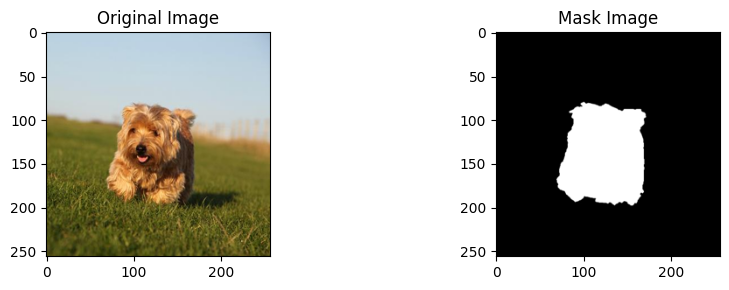

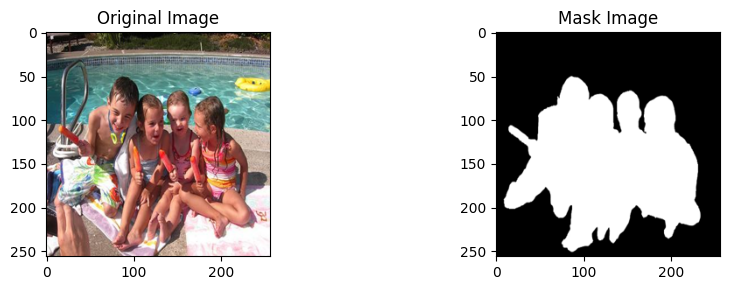

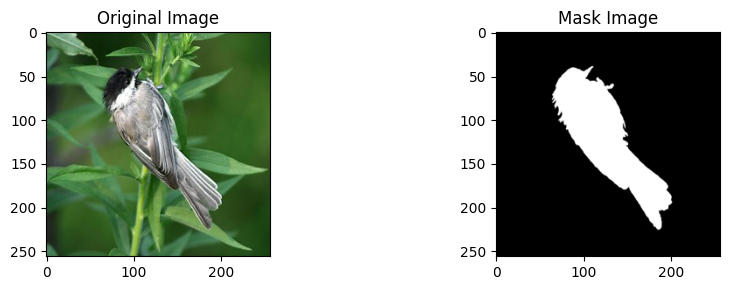

In [11]:
def plot(image,mask,predictedMask = np.array([])):
    axis = 2
    plt.figure(figsize = (10,3))
    if predictedMask.any():
        plt.suptitle("Plotting Prediction")
        axis = 3
        plt.subplot(1, axis, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictedMask, cmap = 'gray')

    plt.subplot(1, axis, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, axis, 2)
    plt.title("Mask Image")
    plt.imshow(mask, cmap = 'gray')

    plt.tight_layout()

for i in range(3) :
    plot(X_trainImages[i],Y_trainImages[i])

In [12]:
def convBlock(input, numFilters) :
    x = tf.keras.layers.Conv2D(numFilters, 3, padding = "same",dilation_rate = 1)(input)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(numFilters, 3, padding = "same",dilation_rate = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    return x

def encoderBlock(input,numFilters) :
    x = convBlock(input,numFilters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x,p

def decoderBlock(input,skipFeatures,numFilters) :
    x = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation="bilinear")(input)
    x = tf.keras.layers.Concatenate()([x,skipFeatures])
    x = convBlock(x, numFilters)
    return x

In [13]:
def buildUnet(inputShape,numLayers = 4,initialFilters = 64):
    inputs = tf.keras.layers.Input(inputShape)

    skipFeatures = []
    x = inputs
    
    for i in range(numLayers):
        s,x = encoderBlock(x, initialFilters * (2**i))
        skipFeatures.append(s)

    b = convBlock(x, initialFilters * (2**numLayers))

    for i in reversed(range(numLayers)):
        b = decoderBlock(b, skipFeatures[i], initialFilters * (2**i))

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(b)
    
    model = tf.keras.models.Model(inputs, outputs, name = "U-Net")
    return model

In [14]:
UnetModel = buildUnet((DataSet.imageSize,DataSet.imageSize, 3))

2025-11-08 04:39:02.220886: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-08 04:39:02.220915: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-11-08 04:39:02.220923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.72 GB
2025-11-08 04:39:02.221098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-08 04:39:02.221108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
def loss(Y_true, Y_pred):
    Y_true = K.cast(Y_true, 'float32')
    Y_pred = K.cast(Y_pred, 'float32')
    return tf.keras.losses.binary_crossentropy(Y_true,Y_pred)

def precision(Y_true, Y_pred):
    Y_true_f = K.flatten(Y_true)
    Y_pred_f = K.flatten(Y_pred)
    Y_true_f = K.cast(Y_true_f, 'float32')
    Y_pred_f = K.cast(Y_pred_f, 'float32')
    truePositives = K.sum(K.round(K.clip(Y_true_f * Y_pred_f, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(Y_pred_f,0,1)))
    precision = truePositives/(predictedPositives + K.epsilon())
    return precision

def recall(Y_true, Y_pred):
    Y_true_f = K.flatten(Y_true)
    Y_pred_f = K.flatten(Y_pred)
    Y_true_f = K.cast(Y_true_f, 'float32')
    Y_pred_f = K.cast(Y_pred_f, 'float32')
    truePositives = K.sum(K.round(K.clip(Y_true_f * Y_pred_f, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(Y_true_f,0,1)))
    recall = truePositives/(possiblePositives + K.epsilon())
    return recall

In [19]:
lossInit = loss
metrics = [precision,recall]

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
UnetModel.compile(optimizer = opt,loss = lossInit,metrics = metrics)

In [21]:
def getCallBack():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best.weights.h5', monitor = 'val_loss',verbose = 1,save_best_only=True,save_weights_only=True,mode = 'min')
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]


In [22]:
history = UnetModel.fit(
    X_trainImages,
    Y_trainImages,
    validation_data=(X_testImages, Y_testImages),
    validation_split=0.2,
    batch_size=8,
    epochs=15,
    callbacks = getCallBack()    
)

Epoch 1/15


2025-11-08 04:41:28.149202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - loss: 0.4092 - precision: 0.6610 - recall: 0.6750
Epoch 1: val_loss improved from inf to 0.28423, saving model to best.weights.h5
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1104s 832ms/step - loss: 0.4091 - precision: 0.6610 - recall: 0.6750 - val_loss: 0.2842 - val_precision: 0.5565 - val_recall: 0.5583 - learning_rate: 1.0000e-04
Epoch 2/15
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 0.2325 - precision: 0.8236 - recall: 0.8236
Epoch 2: val_loss improved from 0.28423 to 0.26059, saving model to best.weights.h5
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1083s 820ms/step - loss: 0.2325 - precision: 0.8236 - recall: 0.8236 - val_loss: 0.2606 - val_precision: 0.5883 - val_recall: 0.6732 - learning_rate: 1.0000e-04
Epoch 3/15
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - loss: 0.1953 - precision: 0.8546 - recall: 0.8539
Epoch 3: val_loss improved from 0.26059 to 0.24223, saving model to best.weights.h5
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1070s 811ms/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


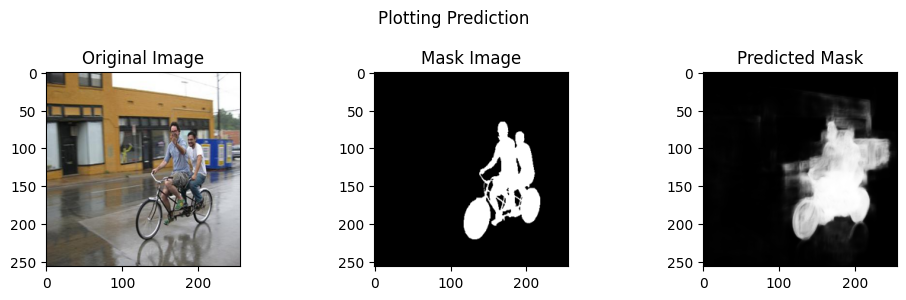

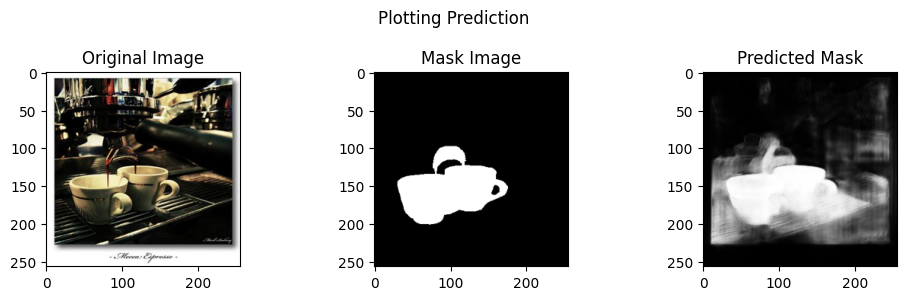

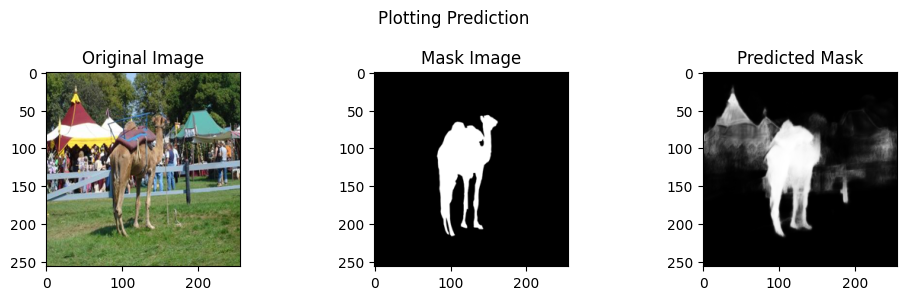

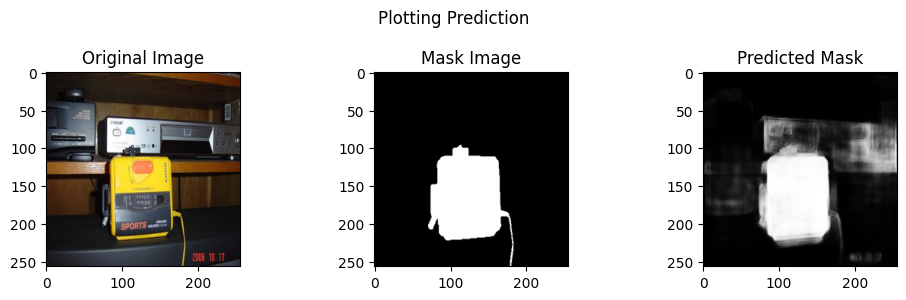

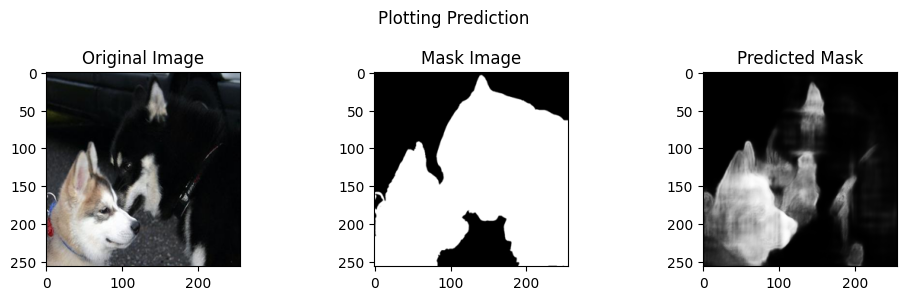

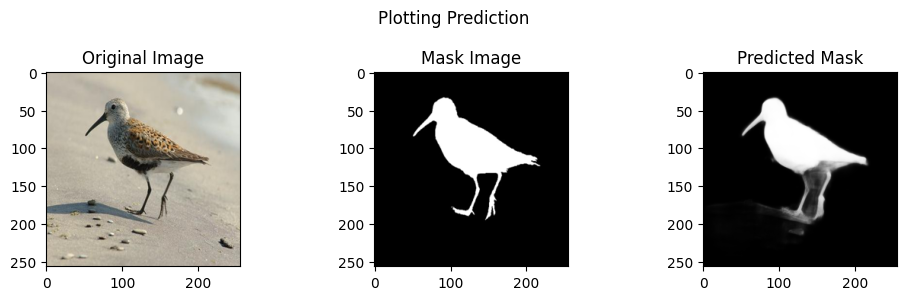

In [25]:
img=[1, 4, 16, 33, 44, 81]
for i in img:
    y_pred = UnetModel.predict(np.reshape(X_testImages[i],(1,DataSet.imageSize,DataSet.imageSize,3)))
    plot(X_testImages[i],Y_testImages[i],y_pred[0])

In [24]:
def evaluate_model(Model,X_test,Y_test):
    y_preds = Model.predict(X_test)

    loss_vals = []
    precision_vals = []
    recall_vals = []

    x_tensor = tf.convert_to_tensor(X_test)
    y_tensor = tf.convert_to_tensor(Y_test)
    y_pred_tensor = tf.convert_to_tensor(y_preds)
    test_loss = loss(y_tensor, y_pred_tensor)
    test_precision = precision(y_tensor, y_pred_tensor)
    test_recall = recall(y_tensor, y_pred_tensor)
    
    print(f"Loss: {float(K.mean(test_loss)):.4f}")
    print(f"Precision: {float(test_precision):.4f}")
    print(f"Recall: {float(test_recall):.4f}")

evaluate_model(UnetModel, X_testImages, Y_testImages)

157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 571ms/step
Loss: 0.2145
Precision: 0.6830
Recall: 0.7493


In [26]:
UnetModel.save('./models/unetmodel-best-sofar.keras')